# Laboratorio 1: Phishing Detection

* Marco Ramirez 21032
* Rebbeca Smith 

## Para instalar las dependencias


```cmd
pip install -r requirements.txt
```

## Parte 1 - Ingenería de características

### Exploración de datos

In [87]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import re
from urllib.parse import urlparse
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt




In [18]:
df = pd.read_csv("dataset_pishing.csv")

df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [ ]:
print(f"Dimensiones del dataset: {df.shape}")

print("\nTipos de datos:")
print(df.dtypes)

print("\nDistribución de clases:")
print(df["status"].value_counts())

print("\nValores nulos por columna:")
print(df.isnull().sum())

Dimensiones del dataset: (11430, 2)

Tipos de datos:
url       object
status    object
dtype: object

Distribución de clases:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64

Valores nulos por columna:
url       0
status    0
dtype: int64


/var/folders/h8/k3gpg6h97wv_mzlyws73msh80000gn/T/ipykernel_81323/1198874874.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["status"], palette="viridis")


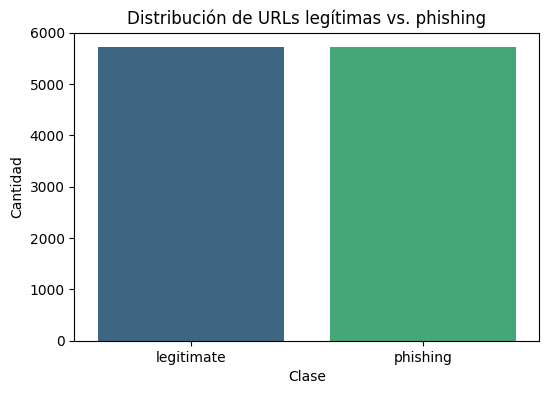

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["status"], palette="viridis")
plt.title("Distribución de URLs legítimas vs. phishing")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

Sí, el dataset está balanceado porque se tiene la misma cantidad de URLs legítimas como de phishing. Esto nos ayuda porque no va haber ninguna inclinación por un tipo de URL 

### Derivación de características

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

* **Velocidad de detección**: No se necesita cargar toda la página web ni hacer consultas externas. Solo se analiza la estructura de la URL
* **Independencia de terceros**: Métodos como la consulta WHOIS o listas negras dependen de servicios externos que pueden no estar actualizados o pueden ser bloqueados por los atacantes.
* **Detección de ataques nuevos (zero-day)**: Las listas negras solo detectan phishing si la URL ya ha sido reportada, mientras que un análisis de la estructura de la URL puede detectar patrones sospechosos en URLs nuevas.
* **Menos costo computacional:** No se necesita renderizar una página ni analizar su contenido en profundidad, lo cual puede ser costoso en términos de recursos.
* **Evita técnicas de evasión**: Los atacantes pueden cambiar dinámicamente el contenido de la página, pero la URL en sí sigue patrones que pueden ser detectados.

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

| Característica | Descripción |  
| ---: | ---: |  
| Longitud de la URL | URLs phishing tienden a ser más largas |  
| Número de guiones (-) | Los atacantes usan guiones para hacer que las URLs se parezcan a sitios legítimos |  
| Número de puntos (.) | Muchas URLs phishing tienen varios subdominios |  
| Número de slashes (/) | URLs con muchas rutas pueden ser sospechosas |  
| Presencia de @ | Redirige a otra página, comportamiento sospechoso |  
| Presencia de IP en lugar de dominio | URLs phishing a veces usan direcciones IP en vez de nombres de dominio |  
| Uso de https | Falta de HTTPS puede ser un indicio de phishing |  
| Uso de palabras clave sospechosas | Palabras como “secure”, “login”, “verify”, “banking” pueden ser usadas para engañar |  
| Número de parámetros en la URL | Muchas URLs phishing contienen múltiples parámetros en la query |  
| Número de caracteres especiales (?, =, &) | URLs phishing pueden usar muchos caracteres especiales para ofuscar |  
| Entropía de Shannon | URLs con mayor aleatoriedad en caracteres tienden a ser phishing |  
| Entropía relativa | Comparación de la entropía con una distribución esperada |  
| Número de números en la URL | Phishers a veces usan números en lugar de letras para imitar dominios legítimos |  
| Número de subdominios | Muchas URLs phishing tienen múltiples subdominios |  
| Uso de TLD sospechosos | Algunos TLDs (ej. .tk, .ml) están asociados con phishing |  

#### 15 funciones

In [98]:
# Función para calcular entropía de Shannon
def shannon_entropy(url):
    prob = [float(url.count(c)) / len(url) for c in set(url)]
    entropy = -sum([p * math.log2(p) for p in prob if p > 0])
    return entropy

# Función para contar caracteres especiales en la URL
def count_special_chars(url, chars="-.@/"):
    return sum(url.count(c) for c in chars)

# Función para verificar si la URL contiene una IP en vez de un dominio
def contains_ip(url):
    regex = r'(\d{1,3}\.){3}\d{1,3}'  # Formato de una dirección IP
    return 1 if re.search(regex, url) else 0

# Función para verificar si la URL usa HTTPS
def uses_https(url):
    return 1 if url.startswith("https") else 0

# Función para contar la cantidad de parámetros en la URL
def count_parameters(url):
    return url.count('?') + url.count('&')

# Función para contar la cantidad de subdominios en la URL
def count_subdomains(url):
    parsed_url = urlparse(url)
    return len(parsed_url.netloc.split('.')) - 2  # Resta 2 porque "www.example.com" tiene solo 1 subdominio

# Función para contar la cantidad de números en la URL
def count_numbers(url):
    return sum(c.isdigit() for c in url)

# Función para verificar si la URL contiene palabras sospechosas
suspicious_words = ["secure", "login", "verify", "banking", "account", "update"]
def contains_suspicious_words(url):
    return 1 if any(word in url.lower() for word in suspicious_words) else 0

# Función para obtener el TLD de la URL
def get_tld(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc.split('.')[-1] if '.' in parsed_url.netloc else ""

# Función para verificar si la URL tiene un TLD sospechoso
suspicious_tlds = ["tk", "ml", "ga", "cf", "gq"]
def is_suspicious_tld(url):
    return 1 if get_tld(url) in suspicious_tlds else 0

# Función para calcular la entropía relativa (comparada con un set de probabilidades esperadas)
expected_probabilities = {
    "-": 0.01, ".": 0.02, "/": 0.05, "@": 0.001, "?": 0.002, "=": 0.003, "&": 0.004
}

# Lista de extensiones sospechosas según los artículos revisados
suspicious_extensions = [".exe", ".zip", ".scr", ".apk", ".js", ".pif", ".bat", ".cmd", ".hta", ".msi"]

def count_suspicious_extensions(url):
    """
    Cuenta cuántas veces aparecen extensiones sospechosas en la URL.

    :param url: La URL a analizar.
    :return: Número de extensiones sospechosas en la URL.
    """
    return sum(url.lower().count(ext) for ext in suspicious_extensions)

def relative_entropy(url):
    observed_probs = {char: url.count(char) / len(url) for char in set(url)}
    return sum(observed_probs[char] * math.log2(observed_probs[char] / expected_probabilities.get(char, 1e-10))
               for char in observed_probs if char in expected_probabilities)

# Agregar todas las funciones al DataFrame
def add_features(df):
    df["url_length"] = df["url"].apply(len)
    df["num_hyphens"] = df["url"].apply(lambda x: x.count('-'))
    df["num_dots"] = df["url"].apply(lambda x: x.count('.'))
    df["num_slashes"] = df["url"].apply(lambda x: x.count('/'))
    df["contains_at"] = df["url"].apply(lambda x: 1 if "@" in x else 0)
    df["contains_ip"] = df["url"].apply(contains_ip)
    df["uses_https"] = df["url"].apply(uses_https)
    df["num_parameters"] = df["url"].apply(count_parameters)
    df["num_numbers"] = df["url"].apply(count_numbers)
    df["num_subdomains"] = df["url"].apply(count_subdomains)
    df["contains_suspicious_words"] = df["url"].apply(contains_suspicious_words)
    df["is_suspicious_tld"] = df["url"].apply(is_suspicious_tld)
    df["entropy"] = df["url"].apply(shannon_entropy)
    df["count_suspicious_extensions"] = df["url"].apply(count_suspicious_extensions)  
    df["relative_entropy"] = df["url"].apply(relative_entropy)

    return df

# Cargar el dataset y aplicar las funciones
df = pd.read_csv("dataset_pishing.csv")
df = add_features(df)

# Mostrar las primeras filas del dataset modificado
df.head()

,url,status,url_length,num_hyphens,num_dots,num_slashes,contains_at,contains_ip,uses_https,num_parameters,num_numbers,num_subdomains,contains_suspicious_words,is_suspicious_tld,entropy,count_suspicious_extensions,relative_entropy
0,http://www.crestonwood.com/router.php,legitimate,37,0,3,3,0,0,0,0,0,1,0,0,3.787043,0,0.220281
1,http://shadetreetechnology.com/V4/validation/a...,phishing,77,0,1,5,0,0,0,0,17,0,0,0,4.419864,0,0.016395
2,https://support-appleld.com.secureupdate.duila...,phishing,126,1,4,5,0,0,1,3,19,3,1,0,4.753412,0,0.123784
3,http://rgipt.ac.in,legitimate,18,0,2,2,0,0,0,0,0,1,0,0,3.461320,0,0.402882
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,55,2,2,5,0,0,0,0,0,1,0,0,4.097662,0,0.177499


| Función | Descripción |  
| ---: | ---: |
| shannon_entropy(url) | Calcula la entropía de Shannon de la URL. |  
| count_special_chars(url) | Cuenta caracteres especiales en la URL. |  
| contains_ip(url) | Detecta si la URL usa una IP en lugar de un dominio. |  
| uses_https(url) | Verifica si la URL usa HTTPS. |  
| count_parameters(url) | Cuenta la cantidad de parámetros en la URL. |  
| count_subdomains(url) | Cuenta cuántos subdominios tiene la URL. |  
| count_numbers(url) | Cuenta la cantidad de números en la URL. |  
| contains_suspicious_words(url) | Detecta palabras sospechosas en la URL. |  
| get_tld(url) | Obtiene el TLD (dominio de nivel superior) de la URL. |  
| is_suspicious_tld(url) | Verifica si el TLD es sospechoso. |  
| relative_entropy(url) | Calcula la entropía relativa de la URL. |  
| url_length(url) | Calcula la longitud total de la URL. |  
| num_hyphens(url) | Cuenta los guiones en la URL. |  
| num_dots(url) | Cuenta los puntos en la URL. |  
| count_suspicious_extensions(url) | Cuenta cuántas veces aparecen extensiones sospechosas en la URL. |  

### Preprocesamiento

In [105]:
df.head()

,url,status,url_length,num_hyphens,num_dots,num_slashes,contains_at,contains_ip,uses_https,num_parameters,num_numbers,num_subdomains,contains_suspicious_words,is_suspicious_tld,entropy,count_suspicious_extensions,relative_entropy
0,http://www.crestonwood.com/router.php,legitimate,37,0,3,3,0,0,0,0,0,1,0,0,3.787043,0,0.220281
1,http://shadetreetechnology.com/V4/validation/a...,phishing,77,0,1,5,0,0,0,0,17,0,0,0,4.419864,0,0.016395
2,https://support-appleld.com.secureupdate.duila...,phishing,126,1,4,5,0,0,1,3,19,3,1,0,4.753412,0,0.123784
3,http://rgipt.ac.in,legitimate,18,0,2,2,0,0,0,0,0,1,0,0,3.461320,0,0.402882
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,55,2,2,5,0,0,0,0,0,1,0,0,4.097662,0,0.177499


In [106]:
df["status"] = df["status"].replace({"legitimate": 0, "phishing": 1}).astype(int)

/var/folders/h8/k3gpg6h97wv_mzlyws73msh80000gn/T/ipykernel_81323/1973564200.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["status"] = df["status"].replace({"legitimate": 0, "phishing": 1}).astype(int)


In [108]:
# Guardar el dataset con nuevas características
df.to_csv("dataset_pishing_features.csv", index=False)

df.head()

,url,status,url_length,num_hyphens,num_dots,num_slashes,contains_at,contains_ip,uses_https,num_parameters,num_numbers,num_subdomains,contains_suspicious_words,is_suspicious_tld,entropy,count_suspicious_extensions,relative_entropy
0,http://www.crestonwood.com/router.php,0,37,0,3,3,0,0,0,0,0,1,0,0,3.787043,0,0.220281
1,http://shadetreetechnology.com/V4/validation/a...,1,77,0,1,5,0,0,0,0,17,0,0,0,4.419864,0,0.016395
2,https://support-appleld.com.secureupdate.duila...,1,126,1,4,5,0,0,1,3,19,3,1,0,4.753412,0,0.123784
3,http://rgipt.ac.in,0,18,0,2,2,0,0,0,0,0,1,0,0,3.461320,0,0.402882
4,http://www.iracing.com/tracks/gateway-motorspo...,0,55,2,2,5,0,0,0,0,0,1,0,0,4.097662,0,0.177499


In [62]:
# Verificar si la columna 'url' o 'domain' existe y eliminarla
if "url" in df.columns:
    df.drop(columns=["url"], inplace=True)

if "domain" in df.columns:
    df.drop(columns=["domain"], inplace=True)

# Mostrar las primeras filas para confirmar que se eliminaron
df.head()

,status,url_length,num_hyphens,num_dots,num_slashes,contains_at,contains_ip,uses_https,num_parameters,num_numbers,num_subdomains,contains_suspicious_words,is_suspicious_tld,entropy,count_suspicious_extensions,relative_entropy
0,0,37,0,3,3,0,0,0,0,0,1,0,0,3.787043,0,0.220281
1,1,77,0,1,5,0,0,0,0,17,0,0,0,4.419864,0,0.016395
2,1,126,1,4,5,0,0,1,3,19,3,1,0,4.753412,0,0.123784
3,0,18,0,2,2,0,0,0,0,0,1,0,0,3.461320,0,0.402882
4,0,55,2,2,5,0,0,0,0,0,1,0,0,4.097662,0,0.177499


In [63]:
# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
status                         0
url_length                     0
num_hyphens                    0
num_dots                       0
num_slashes                    0
contains_at                    0
contains_ip                    0
uses_https                     0
num_parameters                 0
num_numbers                    0
num_subdomains                 0
contains_suspicious_words      0
is_suspicious_tld              0
entropy                        0
count_suspicious_extensions    0
relative_entropy               0
dtype: int64


### Selección de Características

In [65]:
# Verificar columnas constantes
constant_cols = [col for col in df.columns if df[col].nunique() == 1]

print("Columnas constantes:", constant_cols)



Columnas constantes: []


In [67]:
# Aplicar un filtro de varianza
selector = VarianceThreshold(threshold=0.01)  # Elimina columnas con varianza menor a 0.01
df_filtered = pd.DataFrame(selector.fit_transform(df.drop(columns=["status"])), columns=df.drop(columns=["status"]).columns[selector.get_support()])

print("Columnas eliminadas por baja varianza:", set(df.columns) - set(df_filtered.columns))
df = df_filtered  

Columnas eliminadas por baja varianza: {'contains_ip', 'count_suspicious_extensions', 'status', 'is_suspicious_tld'}


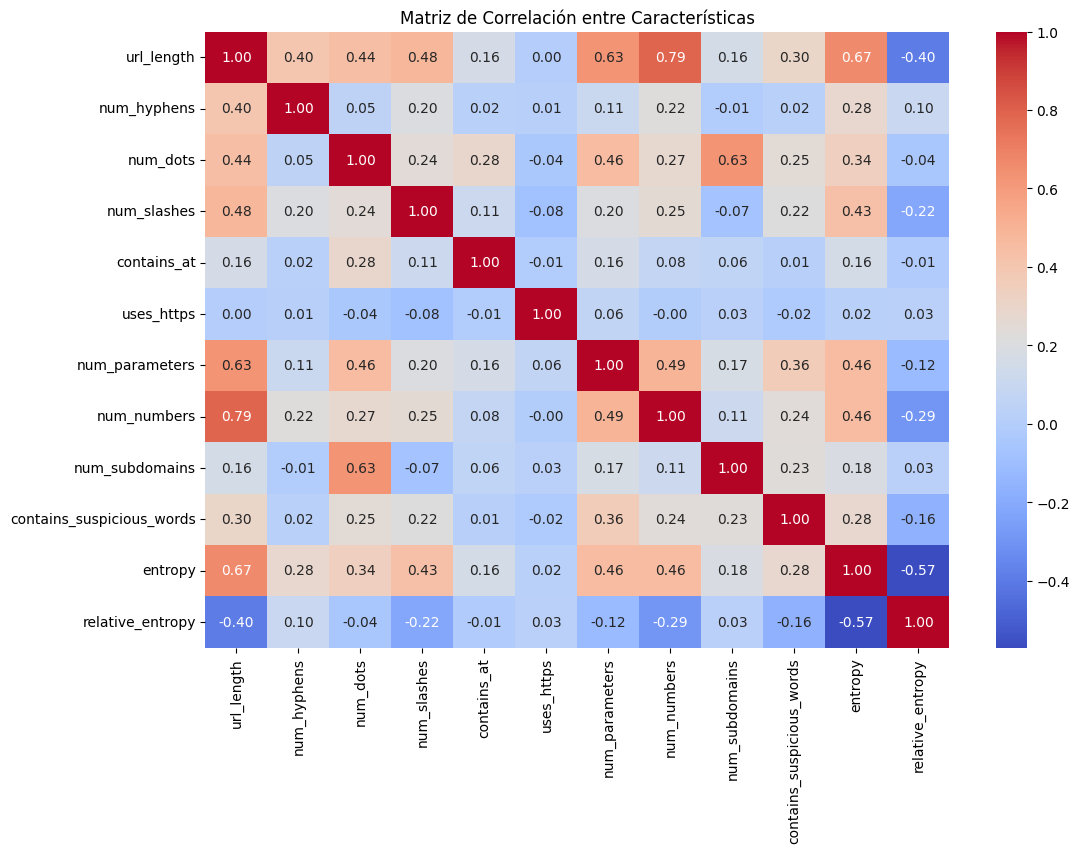

In [68]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Características")
plt.show()

In [ ]:
# Encontrar pares de características con correlación alta
correlation_matrix = df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Columnas con correlación > 0.9
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

print("Columnas con alta correlación:", high_corr_features)

if high_corr_features:
    # Eliminar una de las columnas de cada par con alta correlación
    df.drop(columns=high_corr_features, inplace=True)

Columnas con alta correlación: []


In [72]:
duplicates = df.duplicated().sum()
print(f"Observaciones duplicadas encontradas: {duplicates}")

if duplicates:
    print("Eliminando observaciones duplicadas...")
    df.drop_duplicates(inplace=True)

Observaciones duplicadas encontradas: 1139
Eliminando observaciones duplicadas...


In [73]:
df.head()

,url_length,num_hyphens,num_dots,num_slashes,contains_at,uses_https,num_parameters,num_numbers,num_subdomains,contains_suspicious_words,entropy,relative_entropy
0,37.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,3.787043,0.220281
1,77.0,0.0,1.0,5.0,0.0,0.0,0.0,17.0,0.0,0.0,4.419864,0.016395
2,126.0,1.0,4.0,5.0,0.0,1.0,3.0,19.0,3.0,1.0,4.753412,0.123784
3,18.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,3.461320,0.402882
4,55.0,2.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,4.097662,0.177499


3. ¿Qué columnas o características fueron seleccionadas y por qué?

| Característica | Razón para incluirla |  
| ---: | ---: |  
| url_length | URLs phishing tienden a ser más largas. |  
| num_hyphens | Phishers usan guiones para hacer URLs falsas más creíbles. |  
| num_dots | Muchos subdominios pueden ser un indicio de phishing. |  
| num_slashes | URLs con muchas rutas pueden ser sospechosas. |  
| contains_at | @ en una URL puede indicar un intento de redirección engañosa. |  
| uses_https | Falta de HTTPS puede ser un indicio de phishing. |  
| num_parameters | URLs con muchos parámetros pueden ser sospechosas. |  
| num_numbers | Phishers a veces usan números en lugar de letras para imitar dominios legítimos. |  
| num_subdomains | Muchas URLs phishing tienen múltiples subdominios. |  
| contains_suspicious_words | Algunas palabras en URLs pueden ser usadas para engañar. |  
| entropy | URLs phishing tienden a ser más aleatorias. |  
| relative_entropy | Compara la aleatoriedad con una distribución esperada. |  

In [75]:
print("Columnas en el DataFrame:", df.columns.tolist())

Columnas en el DataFrame: ['url_length', 'num_hyphens', 'num_dots', 'num_slashes', 'contains_at', 'uses_https', 'num_parameters', 'num_numbers', 'num_subdomains', 'contains_suspicious_words', 'entropy', 'relative_entropy']


In [76]:
selected_features = [
    "url_length", "num_hyphens", "num_dots", "num_slashes",
    "contains_at", "uses_https", "num_parameters",
    "num_numbers", "num_subdomains", "contains_suspicious_words",
    "entropy", "relative_entropy"
]

df = df[selected_features]  # Mantener solo estas columnas disponibles
print("Selección de características:", df.columns.tolist())

✅ Selección de características exitosa: ['url_length', 'num_hyphens', 'num_dots', 'num_slashes', 'contains_at', 'uses_https', 'num_parameters', 'num_numbers', 'num_subdomains', 'contains_suspicious_words', 'entropy', 'relative_entropy']


## Parte 2 - Implementación 

### Separación de datos

In [111]:
# Cargar el dataset procesado
df = pd.read_csv("dataset_pishing_features.csv")

# Separar características (X) y etiquetas (y)
X = df.drop(columns=["status"])
y = df["status"]

# Separar en conjunto de entrenamiento (55%) y el resto (45%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, random_state=42, stratify=y)

# Separar lo restante en validación (15%) y prueba (30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6666, random_state=42, stratify=y_temp)

# 📌 Crear carpetas para organizar los archivos
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

# 📁 Guardar los datasets en sus respectivas carpetas
X_train.to_csv("data/train/train_features.csv", index=False)
y_train.to_csv("data/train/train_labels.csv", index=False)

X_val.to_csv("data/val/val_features.csv", index=False)
y_val.to_csv("data/val/val_labels.csv", index=False)

X_test.to_csv("data/test/test_features.csv", index=False)
y_test.to_csv("data/test/test_labels.csv", index=False)

print("Datos separados y organizados ")

Datos separados y organizados 


### Implementación

In [113]:
y_train = y_train.squeeze()  # Convierte DataFrame de una sola columna en un Series
y_train = y_train.astype(int)  # Asegurar que los valores sean enteros

In [116]:
# Cargar los datos corregidos
X_train = pd.read_csv("data/train/train_features.csv")
y_train = pd.read_csv("data/train/train_labels.csv").squeeze().astype(int)  # Convertir a 1D

X_val = pd.read_csv("data/val/val_features.csv")
y_val = pd.read_csv("data/val/val_labels.csv").squeeze().astype(int)

X_test = pd.read_csv("data/test/test_features.csv")
y_test = pd.read_csv("data/test/test_labels.csv").squeeze().astype(int)

# Asegurar que no hay valores NaN
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Verificar que solo haya datos numéricos
X_train = X_train.select_dtypes(include=["number"])
X_val = X_val.select_dtypes(include=["number"])
X_test = X_test.select_dtypes(include=["number"])

# Entrenar los modelos
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [117]:
def evaluate_model(model, X, y, model_name):
    """ Evalúa el modelo y muestra métricas de desempeño """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]  # Probabilidad para la clase phishing (1)

    # 📌 Matriz de Confusión
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legítimo", "Phishing"], yticklabels=["Legítimo", "Phishing"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()

    # 📌 Precision & Recall
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    print(f"\n📌 {model_name} - Precisión: {precision:.4f}, Recall: {recall:.4f}")

    # 📌 Curva ROC y AUC
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title(f"Curva ROC - {model_name}")
    plt.legend()
    plt.show()

    return precision, recall, roc_auc

#### Evaluación en datos de validación 


🔹 Evaluación en Validación


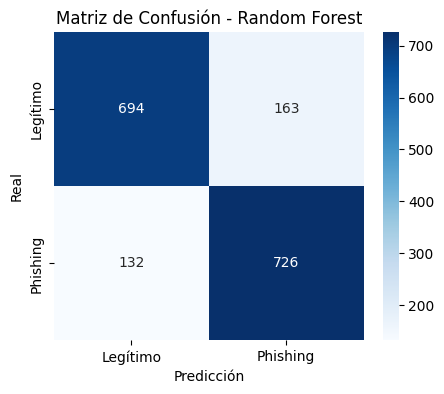


📌 Random Forest - Precisión: 0.8166, Recall: 0.8462


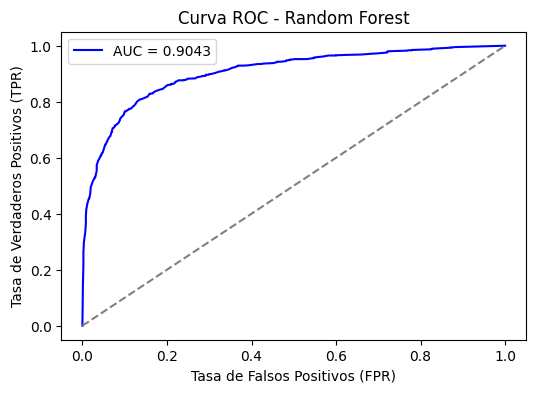

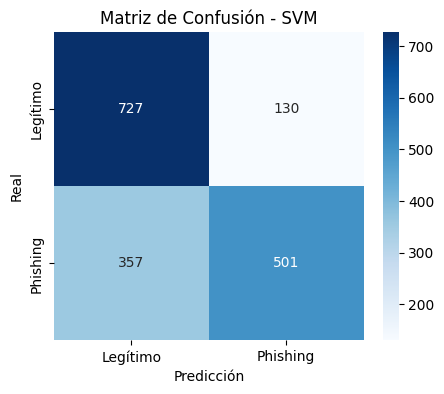


📌 SVM - Precisión: 0.7940, Recall: 0.5839


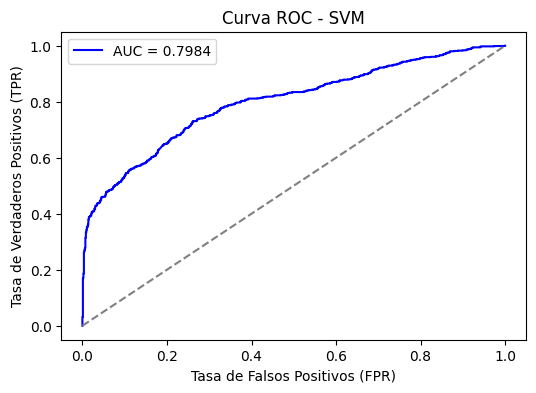

(0.7939778129952456, 0.583916083916084, np.float64(0.7983669383902756))

In [118]:
print("\n🔹 Evaluación en Validación")
evaluate_model(rf_model, X_val, y_val, "Random Forest")
evaluate_model(svm_model, X_val, y_val, "SVM")

#### Evaluación en datos de prueba


🔹 Evaluación en Prueba


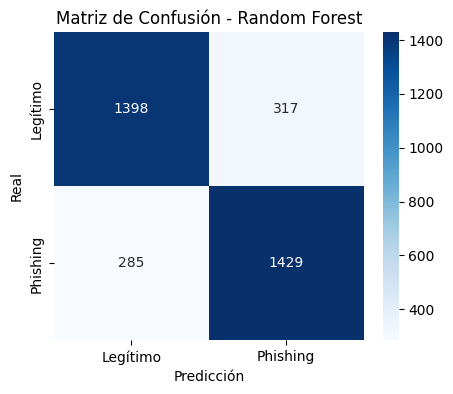


📌 Random Forest - Precisión: 0.8184, Recall: 0.8337


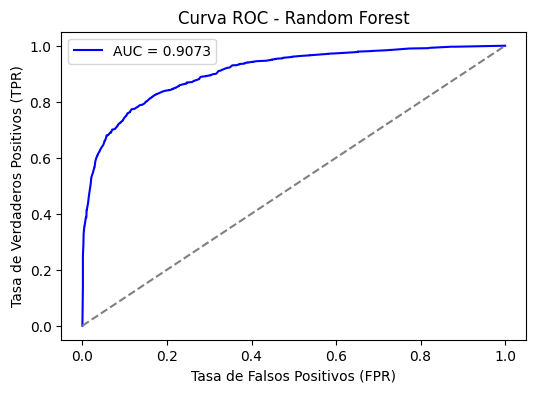

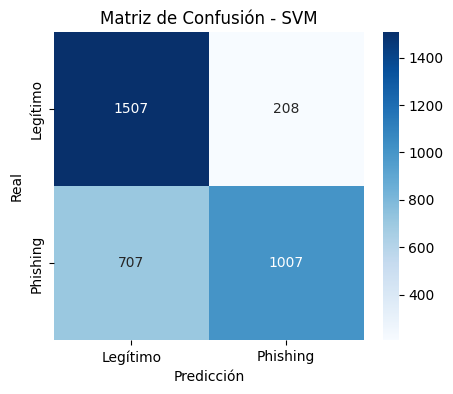


📌 SVM - Precisión: 0.8288, Recall: 0.5875


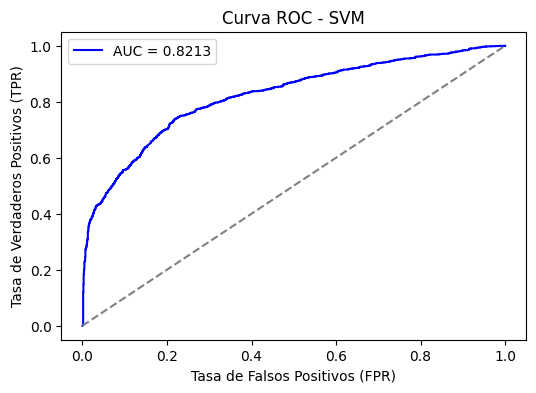

(0.8288065843621399, 0.587514585764294, np.float64(0.8213297454337627))

In [120]:
print("\n🔹 Evaluación en Prueba")
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(svm_model, X_test, y_test, "SVM")